In [1]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
import spacy
import re

In [3]:
from sklearn.metrics import f1_score, jaccard_score, classification_report

In [4]:
# Load data
train = pd.read_csv('/Users/angwang/semeval-task-11-track-a/post-hoc/final-datasets/track_a/train/eng.csv')
val = pd.read_csv('/Users/angwang/semeval-task-11-track-a/post-hoc/final-datasets/track_a/dev/eng.csv')
test = pd.read_csv('/Users/angwang/semeval-task-11-track-a/post-hoc/final-datasets/track_a/test/eng.csv')

# # Define emotions and mapping (model's labels to our labels)
emotions = ['joy', 'sadness', 'surprise', 'fear', 'anger']
emotion_mapping = {
    'joy': 'joy',
    'sadness': 'sadness',
    'surprise': 'surprise',
    'fear': 'fear',
    'anger': 'anger',
    'love': None  # We'll ignore this emotion as it's not in our target set
}

In [5]:
# Preprocessing Config
config = {
    'sep_pn': True, 
    'rm_pn': False, 
    'apply_lemmatization': True, 
    'apply_stemming': True, 
    'add_bigrams': True, 
    'rm_sw': False
}

In [6]:
# Load the pre-trained model and tokenizer
model_name = "bhadresh-savani/bert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [7]:
emolex_path = "/Users/angwang/semeval-task-11-track-a/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

In [8]:
def load_emolex(emolex_path):
    emolex = pd.read_csv(emolex_path, sep='\t', header=None, names=["Word", "Emotion", "Association"])
    # Filter to only include our target emotions
    emolex = emolex[emolex['Emotion'].isin(emotions)]
    
    emotion_dict = {}
    for _, row in emolex.iterrows():
        if row["Association"] == 1:  # Only positive associations
            word = row["Word"].lower()  # Convert to lowercase
            emotion = row["Emotion"].lower()
            if word not in emotion_dict:
                emotion_dict[word] = []
            emotion_dict[word].append(emotion)
    
    print(f"Loaded {len(emotion_dict)} words from EmoLex")
    return emotion_dict

emotion_dict = load_emolex(emolex_path)

Loaded 3155 words from EmoLex


In [9]:
nlp = spacy.load("en_core_web_sm")

# Initialize emotion_matches globally before preprocessing
emotion_matches = {emotion: 0 for emotion in emotions}

for emotion in emotions:
    emotion_words = [word for word, emots in emotion_dict.items() if emotion in emots]
    print(f"\n{emotion} words in lexicon: {len(emotion_words)}")
    print("Sample words:", emotion_words[:5])

# During preprocessing
def pre_process(text, config, target_emotion, emotion_dict):
#     global emotion_matches  # Reference the global variable
    
#     original_text = text  # Save original text for EmoLex matching

#     # First do EmoLex matching on original text
#     emolex_words = []
#     if target_emotion and emotion_dict:
#         # Convert text to lowercase for matching
#         text_lower = original_text.lower()
#         # Find words that appear in both text and emotion lexicon
#         text_words = set(text_lower.split())
#         emolex_words = [word for word in text_words 
#                        if word in emotion_dict 
#                        and target_emotion in emotion_dict[word]]
        
#         if emolex_words:
#             emotion_matches[target_emotion] += 1

    def separate_punctuation(text):
        text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
        text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
        return text

    def remove_punctuation(text):
        text = re.sub(r"[.,;:!?'\"“”\(\)]", "", text)
        return text

    def tokenize_text(text):
        encoded_input = tokenizer(text, return_tensors='pt', add_special_tokens=True)
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
        return tokens

    def apply_stemming(tokens):
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

    def apply_lemmatization(tokens):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]

    def generate_ngrams_from_tokens(tokens, n):
        return [" ".join(gram) for gram in ngrams(tokens, n)]

    # Apply config options
    if config['sep_pn'] and not config['rm_pn']:
        text = separate_punctuation(text)
    if config['rm_pn'] and not config['sep_pn']:
        text = remove_punctuation(text)

    tokens = tokenize_text(text)
    if config['apply_stemming']:
        tokens = apply_stemming(tokens)
    if config['apply_lemmatization']:
        tokens = apply_lemmatization(tokens)
    if config['add_bigrams']:
        tokens += generate_ngrams_from_tokens(tokens, 2)
    if config['rm_sw']:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word.lower() not in stop_words]

    processed_text = " ".join(tokens)

#     # Finally, append EmoLex words if found
#     if emolex_words:
#         processed_text = f"{processed_text} [SEP] {' '.join(emolex_words)}"
#     else:
#         processed_text = f"{processed_text} [SEP]"
    
    return processed_text

# # After preprocessing
# # print("\nEmotion word matches in training data:")
# # for emotion in emotions:
# #     print(f"{emotion}: {emotion_matches[emotion]} texts")


joy words in lexicon: 687
Sample words: ['absolution', 'abundance', 'abundant', 'accolade', 'accompaniment']

sadness words in lexicon: 1187
Sample words: ['abandon', 'abandoned', 'abandonment', 'abduction', 'abortion']

surprise words in lexicon: 532
Sample words: ['abandonment', 'abduction', 'abrupt', 'accident', 'accidental']

fear words in lexicon: 1474
Sample words: ['abandon', 'abandoned', 'abandonment', 'abduction', 'abhor']

anger words in lexicon: 1245
Sample words: ['abandoned', 'abandonment', 'abhor', 'abhorrent', 'abolish']


In [10]:
# Vectorizer Definition
vectorizer = CountVectorizer()

In [11]:
def preprocess_dataset(dataset, emotions, config, emotion_dict):
    global emotion_matches
    emotion_matches = {emotion: 0 for emotion in emotions}  # Reset counters
    
    texts = []
    for text in tqdm(dataset):
        # Get all EmoLex words for any emotion
        text_lower = text.lower()
        text_words = set(text_lower.split())
        emolex_words = []
        
        # Check for words matching any emotion in the lexicon
        for word in text_words:
            if word in emotion_dict:
                matching_emotions = set(emotion_dict[word]) & set(emotions)
                if matching_emotions:
                    emolex_words.append(word)
                    # Update emotion matches counters
                    for emotion in matching_emotions:
                        emotion_matches[emotion] += 1
        
        # Process text normally
        processed = pre_process(text, config, target_emotion=None, emotion_dict=None)
        
        # Append EmoLex words if found
        if emolex_words:
            processed = f"{processed} [SEP] {' '.join(emolex_words)}"
        else:
            processed = f"{processed} [SEP]"
            
        texts.append(processed)
    
    # Print emotion word statistics
    for emotion in emotions:
        print(f"Texts with {emotion}-specific words: {emotion_matches[emotion]}/{len(texts)}")
    
    return texts

# Process datasets
train_texts = preprocess_dataset(train["text"], emotions, config, emotion_dict)
val_texts = preprocess_dataset(val["text"], emotions, config, emotion_dict)
test_texts = preprocess_dataset(test["text"], emotions, config, emotion_dict)

# Fit the vectorizer and transform the data
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_texts).toarray()
X_val = vectorizer.transform(val_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

100%|██████████| 2768/2768 [00:03<00:00, 730.18it/s] 


Texts with joy-specific words: 534/2768
Texts with sadness-specific words: 652/2768
Texts with surprise-specific words: 343/2768
Texts with fear-specific words: 612/2768
Texts with anger-specific words: 518/2768


100%|██████████| 116/116 [00:00<00:00, 1982.33it/s]


Texts with joy-specific words: 22/116
Texts with sadness-specific words: 23/116
Texts with surprise-specific words: 16/116
Texts with fear-specific words: 21/116
Texts with anger-specific words: 18/116


100%|██████████| 2767/2767 [00:02<00:00, 946.98it/s] 


Texts with joy-specific words: 535/2767
Texts with sadness-specific words: 618/2767
Texts with surprise-specific words: 388/2767
Texts with fear-specific words: 618/2767
Texts with anger-specific words: 503/2767


In [12]:
train_texts

['[cls] colorado , middl of nowher . [sep] [cls] colorado colorado , , middl middl of of nowher nowher . . [sep] [SEP]',
 '[cls] thi involv swim a pretti larg lake that wa over my head . [sep] [cls] thi thi involv involv swim swim a a pretti pretti larg larg lake lake that that wa wa over over my my head head . . [sep] [SEP] pretty',
 '[cls] it wa one of my most shame ##ful experi . [sep] [cls] it it wa wa one one of of my my most most shame shame ##ful ##ful experi experi . . [sep] [SEP] shameful',
 '[cls] after all , i had veget come out my ear all for the benefit of the young princ . [sep] [cls] after after all all , , i i had had veget veget come come out out my my ear ear all all for for the the benefit benefit of of the the young young princ princ . . [sep] [SEP]',
 '[cls] then the scream start . [sep] [cls] then then the the scream scream start start . . [sep] [SEP] screaming',
 "[cls] they don ' t fear death , and it seem they believ in rein ##car ##nation . [sep] [cls] they th

In [13]:
# Create the emotion classifier pipeline
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

Device set to use cpu
/Users/angwang/miniforge3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [14]:
def get_predictions_batch(texts, batch_size=32):
    """
    Get predictions for a list of texts in batches
    """
    all_predictions = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        batch_texts = texts[i:i + batch_size]
        predictions = classifier(batch_texts)
        all_predictions.extend(predictions)
    
    return all_predictions

In [15]:
def format_predictions(predictions, emotion_mapping):
    """
    Convert raw predictions to the required format
    """
    formatted_preds = []
    for pred in predictions:
        # Create a dictionary of emotion scores
        scores = {p['label']: p['score'] for p in pred}
        # Map to our required emotions and format
        row = [scores.get(emotion_mapping.get(e, e), 0) for e in emotions]
        formatted_preds.append(row)
    
    return np.array(formatted_preds)

In [16]:
# Convert labels to numpy arrays
y_train = train[emotions].values
y_val = val[emotions].values
y_test = test[emotions].values

In [17]:
# # POS Tagging
# def extract_pos_tags(texts):
#     return [[token.pos_ for token in nlp(text)] for text in texts]

In [18]:
# Get BERT embeddings for training data
print("Getting training BERT predictions...")
train_raw_preds = get_predictions_batch(train['text'].tolist())

print("Getting validation BERT predictions...")
val_raw_preds = get_predictions_batch(val['text'].tolist())

print("Getting test BERT predictions...")
test_raw_preds = get_predictions_batch(test['text'].tolist())

Getting training BERT predictions...


Predicting: 100%|██████████| 87/87 [06:20<00:00,  4.37s/it]


Getting validation BERT predictions...


Predicting: 100%|██████████| 4/4 [00:13<00:00,  3.44s/it]


Getting test BERT predictions...


Predicting: 100%|██████████| 87/87 [07:18<00:00,  5.04s/it]


In [19]:
train_bert_features = format_predictions(train_raw_preds, emotion_mapping)
val_bert_features = format_predictions(val_raw_preds, emotion_mapping)
test_bert_features = format_predictions(test_raw_preds, emotion_mapping)

In [20]:
# for emotion in emotions:
#     print(f"Emotion: {emotion}")
#     print(f"Train Vectorizer Shape: {X_train[emotion].shape}")
#     print(f"Val Vectorizer Shape: {X_val[emotion].shape}")
#     print(f"Train BERT Shape: {train_bert_features.shape}")
#     print(f"Val BERT Shape: {val_bert_features.shape}")
#     print(f"Train POS Shape: {train_pos_encoded.shape}")
#     print(f"Val POS Shape: {val_pos_encoded.shape}")

In [21]:
# Combine features for each emotion separately
final_train_features = np.hstack([
    X_train,
    train_bert_features
])

final_val_features = np.hstack([
    X_val,
    val_bert_features
])

final_test_features = np.hstack([
    X_test,
    test_bert_features
])

# print("Combining features for each emotion...")
# for emotion in emotions:
#     print(f"\nProcessing {emotion}:")
#     print(f"X_train shape: {X_train[emotion].shape}")
#     print(f"train_bert_features shape: {train_bert_features.shape}")
#     print(f"train_pos_encoded shape: {train_pos_encoded.shape}")
    
#     final_train_features[emotion] = np.hstack([
#         X_train[emotion],
#         train_bert_features,
#         train_pos_encoded
#     ])
    
#     final_val_features[emotion] = np.hstack([
#         X_val[emotion],
#         val_bert_features,
#         val_pos_encoded
#     ])
    
#     final_test_features[emotion] = np.hstack([
#         X_test[emotion],
#         test_bert_features,
#         test_pos_encoded
#     ])
    
#     print(f"Final features shape for {emotion}: {final_train_features[emotion].shape}")

In [22]:
# Create a model for each emotion
models = {}
for emotion in emotions:
    input_size = final_train_features.shape[1]  # Get the feature size for all emotions
    models[emotion] = nn.Sequential(
        nn.Linear(input_size, 256),  # Use the correct input size
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

In [23]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [24]:
# for emotion in emotions:

#     print(f"Feature size for {emotion}: {final_train_features[emotion].shape[1]}")

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for joy
Validation features shape for joy: torch.Size([116, 4345])


Training Loop (joy):   0%|          | 1/401 [00:01<10:33,  1.58s/it]


Epoch 0 (joy):
Training Loss: 0.9470, Validation Loss: 0.9547
Macro F1: 0.6390

New best model for joy at epoch 0 with F1: 0.6390


Training Loop (joy):   0%|          | 2/401 [00:03<10:27,  1.57s/it]


New best model for joy at epoch 1 with F1: 0.6763


Training Loop (joy):   1%|          | 3/401 [00:04<10:09,  1.53s/it]


New best model for joy at epoch 2 with F1: 0.6862


Training Loop (joy):   1%|          | 5/401 [00:07<10:09,  1.54s/it]


New best model for joy at epoch 4 with F1: 0.7159


Training Loop (joy):   2%|▏         | 7/401 [00:12<13:28,  2.05s/it]


New best model for joy at epoch 6 with F1: 0.7175


Training Loop (joy):   2%|▏         | 8/401 [00:16<17:00,  2.60s/it]


New best model for joy at epoch 7 with F1: 0.7220


Training Loop (joy):   3%|▎         | 11/401 [00:20<11:45,  1.81s/it]


Epoch 10 (joy):
Training Loss: 0.1074, Validation Loss: 2.0009
Macro F1: 0.7361

New best model for joy at epoch 10 with F1: 0.7361


Training Loop (joy):   5%|▍         | 20/401 [00:31<07:40,  1.21s/it]


New best model for joy at epoch 19 with F1: 0.7498


Training Loop (joy):   5%|▌         | 21/401 [00:32<07:42,  1.22s/it]


Epoch 20 (joy):
Training Loss: 0.0397, Validation Loss: 2.3698
Macro F1: 0.7274


Training Loop (joy):   7%|▋         | 29/401 [00:44<09:35,  1.55s/it]


Early stopping triggered at epoch 29

Loaded best model for joy from epoch 19 with F1: 0.7498



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_52650/734197230.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoint

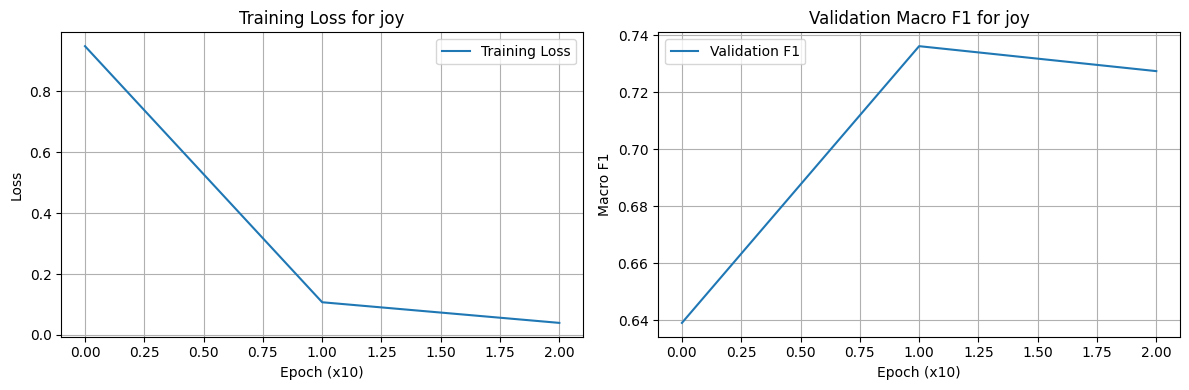

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for sadness
Validation features shape for sadness: torch.Size([116, 4345])


Training Loop (sadness):   0%|          | 1/401 [00:01<08:55,  1.34s/it]


Epoch 0 (sadness):
Training Loss: 0.8800, Validation Loss: 0.7079
Macro F1: 0.7785

New best model for sadness at epoch 0 with F1: 0.7785


Training Loop (sadness):   2%|▏         | 10/401 [00:14<09:45,  1.50s/it]


Epoch 10 (sadness):
Training Loss: 0.0487, Validation Loss: 1.3671
Macro F1: 0.7494

Early stopping triggered at epoch 10

Loaded best model for sadness from epoch 0 with F1: 0.7785



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_52650/734197230.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoint

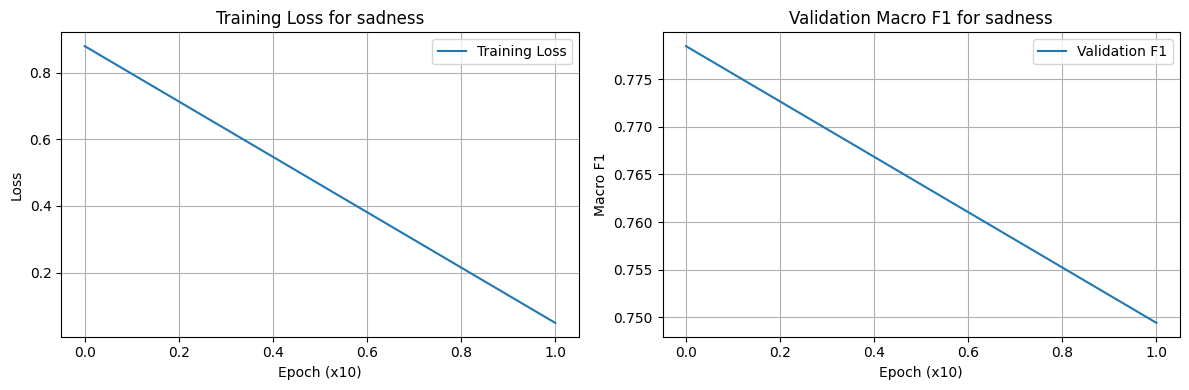

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for surprise
Validation features shape for surprise: torch.Size([116, 4345])


Training Loop (surprise):   0%|          | 1/401 [00:01<08:21,  1.25s/it]


Epoch 0 (surprise):
Training Loss: 0.8515, Validation Loss: 0.7289
Macro F1: 0.6379

New best model for surprise at epoch 0 with F1: 0.6379


Training Loop (surprise):   0%|          | 2/401 [00:02<08:26,  1.27s/it]


New best model for surprise at epoch 1 with F1: 0.6979


Training Loop (surprise):   1%|          | 4/401 [00:04<08:09,  1.23s/it]


New best model for surprise at epoch 3 with F1: 0.7088


Training Loop (surprise):   3%|▎         | 11/401 [00:19<13:57,  2.15s/it]


Epoch 10 (surprise):
Training Loss: 0.0945, Validation Loss: 1.6069
Macro F1: 0.6803


Training Loop (surprise):   3%|▎         | 13/401 [00:24<12:21,  1.91s/it]


Early stopping triggered at epoch 13

Loaded best model for surprise from epoch 3 with F1: 0.7088



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_52650/734197230.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoint

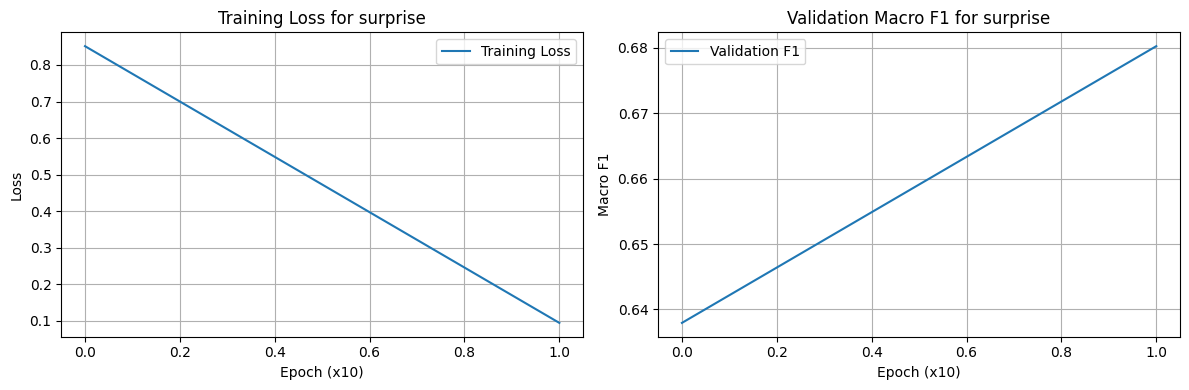

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for fear
Validation features shape for fear: torch.Size([116, 4345])


Training Loop (fear):   0%|          | 1/401 [00:03<20:05,  3.01s/it]


Epoch 0 (fear):
Training Loss: 0.5365, Validation Loss: 0.5139
Macro F1: 0.6542

New best model for fear at epoch 0 with F1: 0.6542


Training Loop (fear):   1%|▏         | 6/401 [00:10<10:54,  1.66s/it]


New best model for fear at epoch 5 with F1: 0.6581


Training Loop (fear):   3%|▎         | 11/401 [00:17<09:11,  1.41s/it]


Epoch 10 (fear):
Training Loss: 0.0667, Validation Loss: 1.2350
Macro F1: 0.6085


Training Loop (fear):   4%|▎         | 15/401 [00:24<10:18,  1.60s/it]


Early stopping triggered at epoch 15

Loaded best model for fear from epoch 5 with F1: 0.6581



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_52650/734197230.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoint

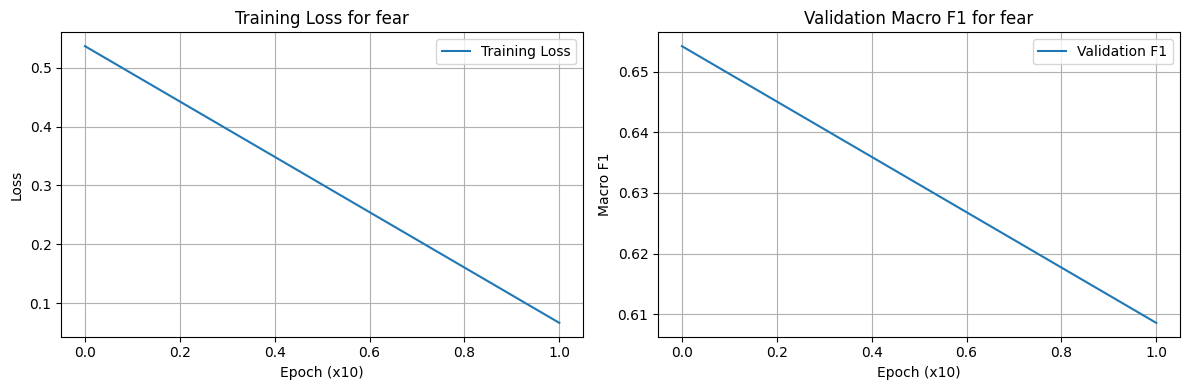

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for anger
Validation features shape for anger: torch.Size([116, 4345])


Training Loop (anger):   0%|          | 1/401 [00:02<14:16,  2.14s/it]


Epoch 0 (anger):
Training Loss: 1.1484, Validation Loss: 0.9769
Macro F1: 0.5771

New best model for anger at epoch 0 with F1: 0.5771


Training Loop (anger):   0%|          | 2/401 [00:03<12:02,  1.81s/it]


New best model for anger at epoch 1 with F1: 0.6176


Training Loop (anger):   1%|          | 4/401 [00:06<09:48,  1.48s/it]


New best model for anger at epoch 3 with F1: 0.7140


Training Loop (anger):   1%|          | 5/401 [00:07<09:57,  1.51s/it]


New best model for anger at epoch 4 with F1: 0.7195


Training Loop (anger):   1%|▏         | 6/401 [00:09<09:28,  1.44s/it]


New best model for anger at epoch 5 with F1: 0.7380


Training Loop (anger):   3%|▎         | 11/401 [00:15<07:18,  1.12s/it]


Epoch 10 (anger):
Training Loss: 0.1328, Validation Loss: 2.0297
Macro F1: 0.6898


Training Loop (anger):   3%|▎         | 13/401 [00:16<06:43,  1.04s/it]


New best model for anger at epoch 12 with F1: 0.7482


Training Loop (anger):   5%|▌         | 21/401 [00:25<07:46,  1.23s/it]


Epoch 20 (anger):
Training Loss: 0.0199, Validation Loss: 1.7944
Macro F1: 0.7186


Training Loop (anger):   5%|▌         | 22/401 [00:27<07:59,  1.27s/it]


Early stopping triggered at epoch 22

Loaded best model for anger from epoch 12 with F1: 0.7482



/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_52650/734197230.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoint

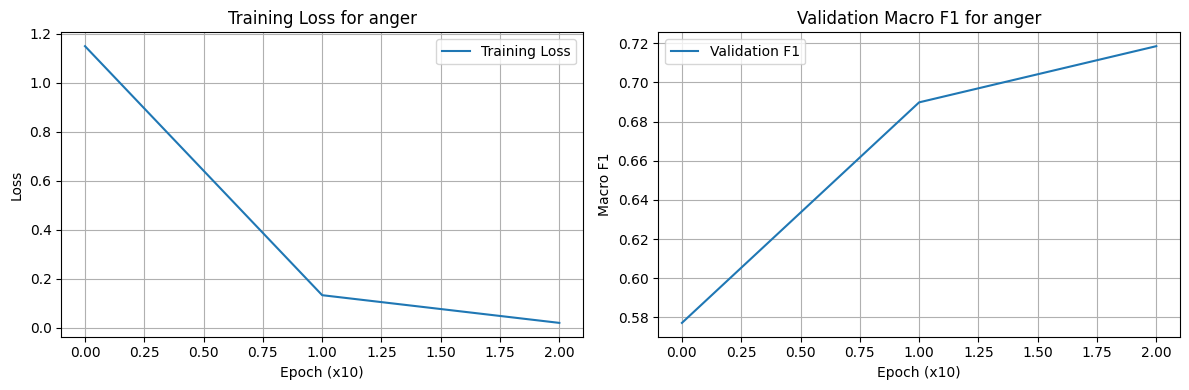

In [25]:
# Training loop for each emotion
for emotion in emotions:
    print(f"\nTraining model for {emotion}")
    model = models[emotion]
    model.train()  # Add this to explicitly set training mode
    
    # Prepare data for this emotion
    features_tensor = torch.tensor(final_train_features, dtype=torch.float32)
    labels_tensor = torch.tensor(y_train[:, emotions.index(emotion)], dtype=torch.float32).unsqueeze(1)
    
    # Add validation tensors
    val_features_tensor = torch.tensor(final_val_features, dtype=torch.float32)
    val_labels_tensor = torch.tensor(y_val[:, emotions.index(emotion)], dtype=torch.float32).unsqueeze(1)
    print(f"Validation features shape for {emotion}: {val_features_tensor.shape}")
    
    dataset = TensorDataset(features_tensor, labels_tensor)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # Increased batch size

    # Calculate class weights for this emotion
    pos_weight = (len(labels_tensor) - labels_tensor.sum()) / labels_tensor.sum()
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Better handling of class imbalance
    
    # Use Adam optimizer with learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

    # Training loop
    best_f1 = 0
    patience = 10
    patience_counter = 0
    train_losses = []
    val_f1s = []
    
    for epoch in tqdm(range(401), desc=f"Training Loop ({emotion})"):
        # Training phase
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for features, labels in data_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            batch_count += 1

        avg_train_loss = epoch_loss / batch_count
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_features_tensor)
            val_preds = (torch.sigmoid(val_outputs).squeeze() > 0.5).float()
            val_labels = val_labels_tensor.squeeze()
            
            # Calculate metrics
            val_loss = criterion(val_outputs, val_labels_tensor)
            macro_f1 = f1_score(
                val_labels.cpu().numpy(),
                val_preds.cpu().numpy(),
                average='macro',
                zero_division=0
            )

        # Learning rate scheduling
        scheduler.step(macro_f1)

        if epoch % 10 == 0:  # More frequent logging
            print(f'\nEpoch {epoch} ({emotion}):')
            print(f'Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Macro F1: {macro_f1:.4f}')
            train_losses.append(avg_train_loss)
            val_f1s.append(macro_f1)
        
        # Save best model
        if macro_f1 > best_f1:
            best_f1 = macro_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_train_loss,
                'f1': macro_f1
            }, f'./model_checkpoints/BERT-FE-Emo-{emotion}_best.pth')
            print(f"\nNew best model for {emotion} at epoch {epoch} with F1: {macro_f1:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

    # Load best model for this emotion
    checkpoint = torch.load(f'./model_checkpoints/BERT-FE-Emo-{emotion}_best.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nLoaded best model for {emotion} from epoch {checkpoint['epoch']} with F1: {checkpoint['f1']:.4f}")

    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.title(f'Training Loss for {emotion}')
    plt.xlabel('Epoch (x10)')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(len(val_f1s)), val_f1s, label='Validation F1')
    plt.title(f'Validation Macro F1 for {emotion}')
    plt.xlabel('Epoch (x10)')
    plt.ylabel('Macro F1')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Complete same training loop for all emotions using macro F1 score

In [26]:
# Save predictions
def save_predictions(predictions, ids, filename):
    df_predictions = pd.DataFrame(predictions, columns=emotions)
    df_predictions['id'] = ids
    df_predictions = df_predictions[['id'] + emotions]
    df_predictions.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")

# Save validation and test predictions
from datetime import datetime
timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')


Generating predictions for joy...
Using best joy model from epoch 19 with F1: 0.7498

Generating predictions for sadness...
Using best sadness model from epoch 0 with F1: 0.7785

Generating predictions for surprise...
Using best surprise model from epoch 3 with F1: 0.7088

Generating predictions for fear...


/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_52650/896250449.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoints

Using best fear model from epoch 5 with F1: 0.6581

Generating predictions for anger...
Using best anger model from epoch 12 with F1: 0.7482

Performing threshold grid search for joy...


Testing thresholds for joy: 100%|██████████| 16/16 [00:00<00:00, 379.76it/s]


Best Results for joy:

Best Results for Emotion Specific MLPs on BERT predictions:
Best Threshold: 0.3000
Best Binary F1: 0.621


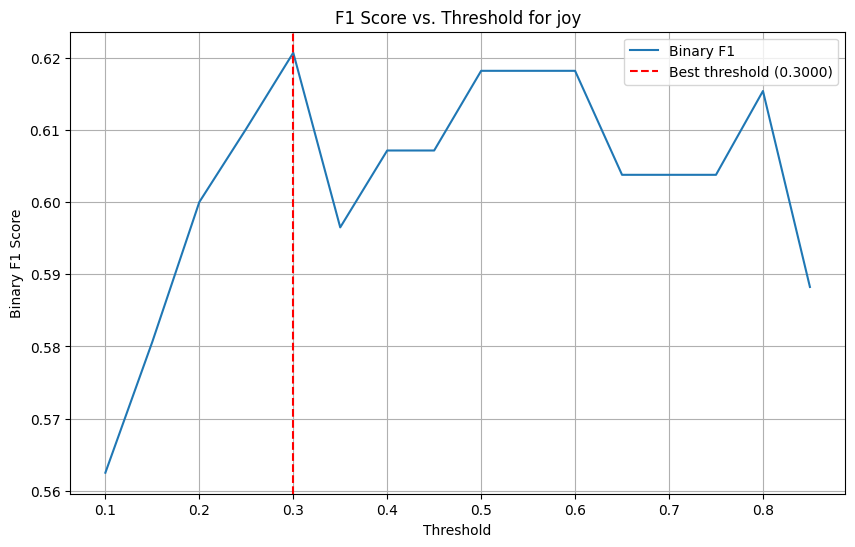


Performing threshold grid search for sadness...


Testing thresholds for sadness: 100%|██████████| 16/16 [00:00<00:00, 678.37it/s]


Best Results for sadness:

Best Results for Emotion Specific MLPs on BERT predictions:
Best Threshold: 0.5000
Best Binary F1: 0.694


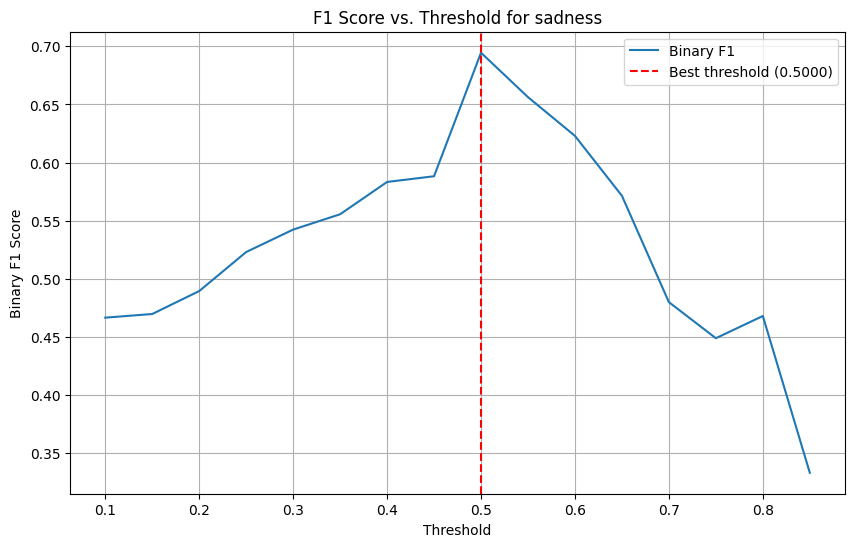


Performing threshold grid search for surprise...


Testing thresholds for surprise: 100%|██████████| 16/16 [00:00<00:00, 663.16it/s]



Best Results for surprise:

Best Results for Emotion Specific MLPs on BERT predictions:
Best Threshold: 0.3500
Best Binary F1: 0.620


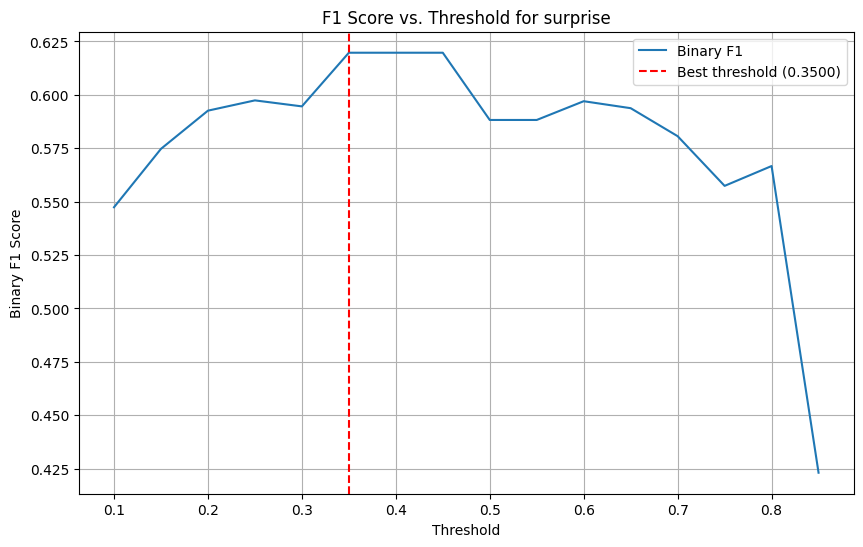


Performing threshold grid search for fear...


Testing thresholds for fear: 100%|██████████| 16/16 [00:00<00:00, 805.44it/s]


Best Results for fear:

Best Results for Emotion Specific MLPs on BERT predictions:
Best Threshold: 0.1000
Best Binary F1: 0.703


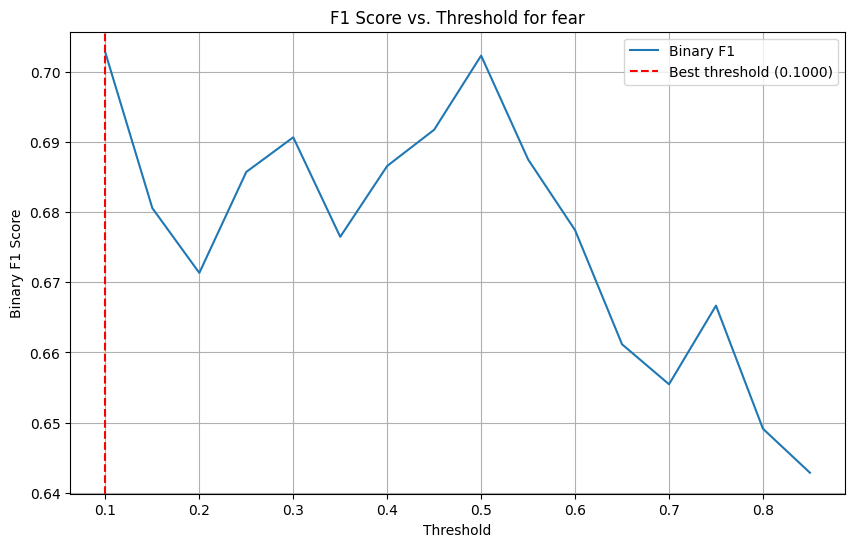


Performing threshold grid search for anger...


Testing thresholds for anger: 100%|██████████| 16/16 [00:00<00:00, 707.19it/s]


Best Results for anger:

Best Results for Emotion Specific MLPs on BERT predictions:
Best Threshold: 0.4000
Best Binary F1: 0.579


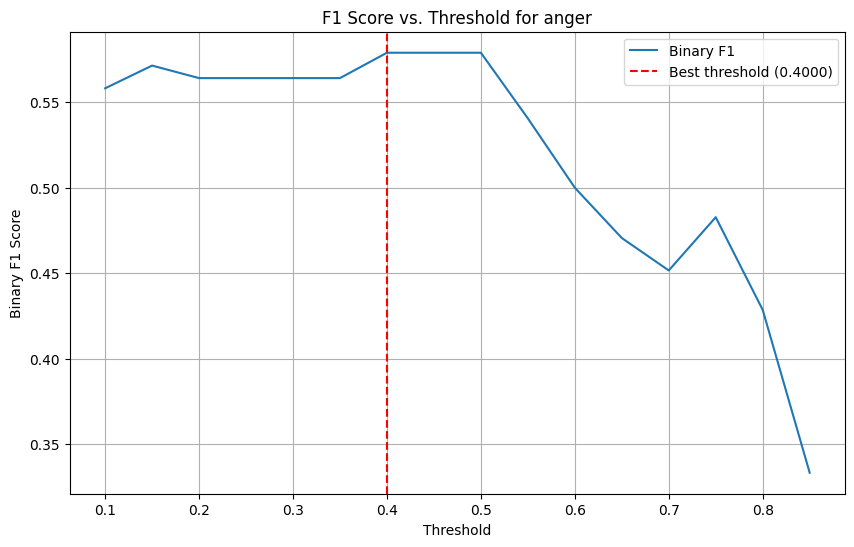


Final Validation Performance with Emotion-Specific Thresholds and Emotion Specific MLPs:
              precision    recall  f1-score   support

         joy     0.6667    0.5806    0.6207        31
     sadness     0.6757    0.7143    0.6944        35
    surprise     0.5500    0.7097    0.6197        31
        fear     0.6118    0.8254    0.7027        63
       anger     0.5000    0.6875    0.5789        16

   micro avg     0.6066    0.7273    0.6615       176
   macro avg     0.6008    0.7035    0.6433       176
weighted avg     0.6131    0.7273    0.6607       176
 samples avg     0.5989    0.6523    0.5961       176


Final Test Performance with Emotion-Specific Thresholds and Emotion Specific MLPs:


/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/User

              precision    recall  f1-score   support

         joy     0.5096    0.5925    0.5480       670
     sadness     0.5649    0.5585    0.5616       881
    surprise     0.4907    0.6608    0.5632       799
        fear     0.6789    0.8258    0.7452      1544
       anger     0.3307    0.3975    0.3611       322

   micro avg     0.5650    0.6689    0.6126      4216
   macro avg     0.5150    0.6070    0.5558      4216
weighted avg     0.5659    0.6689    0.6117      4216
 samples avg     0.5547    0.6070    0.5463      4216

Saved predictions to ./results/BERT-FE-Emo_val_2025-02-22_18_31_08.csv
Saved predictions to ./results/BERT-FE-Emo_test_2025-02-22_18_31_08.csv

Per-emotion Validation Performance at Emotion-Specific Thresholds and Emotion Specific MLPs:
joy: F1 = 0.7471
sadness: F1 = 0.7785
surprise: F1 = 0.7260
fear: F1 = 0.5894
anger: F1 = 0.7482

Per-emotion Test Performance at Emotion-Specific Thresholds and Emotion Specific MLPs:
joy: F1 = 0.6938
sadness: F1 = 0.67

In [27]:
# After training loop finishes for all emotions...

# Make predictions for each emotion using best models
# print("\nGenerating predictions for {emotion}...")
val_preds = {}
test_preds = {}

for emotion in emotions:
    print(f"\nGenerating predictions for {emotion}...")
    # Load the best model for this emotion
    model = models[emotion]
    checkpoint = torch.load(f'./model_checkpoints/BERT-FE-Emo-{emotion}_best.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    
    print(f"Using best {emotion} model from epoch {checkpoint['epoch']} with F1: {checkpoint['f1']:.4f}")
    
    with torch.no_grad():
        # Get raw probabilities using sigmoid
        val_outputs = model(torch.tensor(final_val_features, dtype=torch.float32))
        val_probs = torch.sigmoid(val_outputs).numpy()
        val_preds[emotion] = val_probs
        
        test_outputs = model(torch.tensor(final_test_features, dtype=torch.float32))
        test_probs = torch.sigmoid(test_outputs).numpy()
        test_preds[emotion] = test_probs

# Combine predictions
val_probs = np.hstack([val_preds[emotion] for emotion in emotions])
test_probs = np.hstack([test_preds[emotion] for emotion in emotions])

# Initialize a dictionary to store the best threshold for each emotion
best_thresholds = {emotion: 0 for emotion in emotions}
best_binary_f1s = {emotion: 0 for emotion in emotions}

# Perform threshold grid search for each emotion
for i, emotion in enumerate(emotions):
    print(f"\nPerforming threshold grid search for {emotion}...")
    thresholds = np.arange(0.1, 0.9, 0.05)
    results = []

    for threshold in tqdm(thresholds, desc=f"Testing thresholds for {emotion}"):
        # Convert probabilities to binary predictions for this emotion
        val_binary_preds = (val_probs[:, i] > threshold).astype(int)

        # Calculate metrics
        binary_f1 = f1_score(val[emotions].values[:, i], val_binary_preds, average='binary')  # Changed from 'binary' to 'macro'

        results.append({
            'threshold': threshold,
            'binary_f1': binary_f1
        })

        # Update best threshold if we found better macro F1
        if binary_f1 > best_binary_f1s[emotion]:
            best_binary_f1s[emotion] = binary_f1
            best_thresholds[emotion] = threshold

    # Convert results to DataFrame and display
    results_df = pd.DataFrame(results)
    print(f"\nBest Results for {emotion}:")
    print(f"\nBest Results for Emotion Specific MLPs on BERT predictions:")
    print(f"Best Threshold: {best_thresholds[emotion]:.4f}")
    print(f"Best Binary F1: {best_binary_f1s[emotion]:.3f}")
    # print(f"Best Macro F1: {best_macro_f1s[emotion]:.3f}")

    # Plot the threshold search results for this emotion
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['threshold'], results_df['binary_f1'], label='Binary F1')
    plt.axvline(x=best_thresholds[emotion], color='r', linestyle='--', 
                label=f'Best threshold ({best_thresholds[emotion]:.4f})')
    plt.xlabel('Threshold')
    plt.ylabel('Binary F1 Score')
    plt.title(f'F1 Score vs. Threshold for {emotion}')
    plt.legend()
    plt.grid(True)
    plt.show()

# # Generate final predictions using threshold of 0.5
# val_binary_preds = (val_probs > 0.5).astype(int)  # Direct assignment instead of zeros
# test_binary_preds = (test_probs > 0.5).astype(int)  # Direct assignment instead of zeros
# Generate final predictions using best thresholds for each emotion
val_binary_preds = np.zeros_like(val_probs, dtype=int)
test_binary_preds = np.zeros_like(test_probs, dtype=int)

for i, emotion in enumerate(emotions):
    val_binary_preds[:, i] = (val_probs[:, i] > best_thresholds[emotion]).astype(int)
    test_binary_preds[:, i] = (test_probs[:, i] > best_thresholds[emotion]).astype(int)

# Print detailed performance report
print("\nFinal Validation Performance with Emotion-Specific Thresholds and Emotion Specific MLPs:")
print(classification_report(
    val[emotions].values,
    val_binary_preds,
    target_names=emotions,
    digits=4
))

print("\nFinal Test Performance with Emotion-Specific Thresholds and Emotion Specific MLPs:")
print(classification_report(
    test[emotions].values,
    test_binary_preds,
    target_names=emotions,
    digits=4
))

# Save predictions
timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

# Save validation predictions
save_predictions(
    val_binary_preds,
    val['id'],
    f'./results/BERT-FE-Emo_val_{timestamp}.csv'
)

# Save test predictions
save_predictions(
    test_binary_preds,
    test['id'],
    f'./results/BERT-FE-Emo_test_{timestamp}.csv'
)

# Save threshold search results
results_df.to_csv(f'./results/BERT-FE-Emo-thresholds-{timestamp}.csv', index=False)

# Print per-emotion performance
print("\nPer-emotion Validation Performance at Emotion-Specific Thresholds and Emotion Specific MLPs:")
for i, emotion in enumerate(emotions):
    emotion_f1 = f1_score(
        val[emotions].values[:, i],
        val_binary_preds[:, i],
        average='macro'  # Changed from 'binary' to 'macro'
    )
    print(f"{emotion}: F1 = {emotion_f1:.4f}")

print("\nPer-emotion Test Performance at Emotion-Specific Thresholds and Emotion Specific MLPs:")
for i, emotion in enumerate(emotions):
    emotion_f1 = f1_score(
        test[emotions].values[:, i],
        test_binary_preds[:, i],
        average='macro'  # Changed from 'binary' to 'macro'
    )
    print(f"{emotion}: F1 = {emotion_f1:.4f}")